In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;

/home/csc/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [99]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

In [100]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [101]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

In [102]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [103]:
train.describe(include=['O', 'category'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Graham, Mr. George Edward",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


[2 1 0 3]


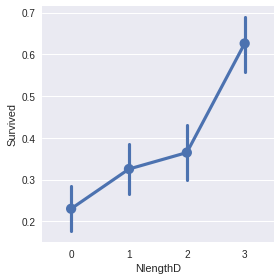

In [121]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
for dataset in full_data:
    dataset['Name_length'] = dataset['Name'].apply(len)
    dataset['NlengthD'] = pd.qcut(dataset['Name_length'], 4, labels=[0,1,2,3]).astype(int)
sns.factorplot(x="NlengthD", y="Survived", data=train,order=[0,1,2,3])
print(train["NlengthD"].unique())

[ 1.  0.  2.]
0.0    537
1.0    263
2.0     91
Name: FsizeD, dtype: int64


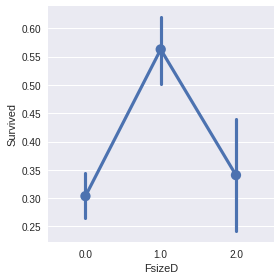

In [105]:
# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
smallbig=3
for dataset in full_data:
    dataset.loc[dataset["FamilySize"] == 1, "FsizeD"] = 0
    dataset.loc[(dataset["FamilySize"] > 1)  &  (dataset["FamilySize"] <= smallbig) , "FsizeD"] = 1
    dataset.loc[dataset["FamilySize"] >smallbig, "FsizeD"] = 2

print(train["FsizeD"].unique())
print(train["FsizeD"].value_counts())
sns.factorplot(x="FsizeD", y="Survived", data=train);
del dataset['FamilySize']

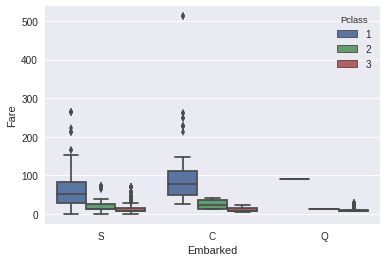

In [106]:
sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=train);
train[train['Embarked'].isnull()]
train["Embarked"] = train["Embarked"].fillna('C')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare

In [107]:
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,FsizeD
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,18,0.0


In [108]:
median = test[(test.Pclass==3)&(test.Embarked=='S')]['Fare'].median()
test["Fare"] = test["Fare"].fillna(median)

In [109]:
for dataset in full_data:
    for i in ['male','female']:
        for j in range(1, 4):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j)]['Age'].dropna()

            age_mean = guess_df.mean()
            age_std = guess_df.std()
            size=dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j)]['Age'].isnull().sum()
            guess_ages = np.random.randint(age_mean - age_std, age_mean + age_std,size=size)
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j),\
                    'Age'] = guess_ages

    dataset['Age'] = dataset['Age'].astype(int)

In [110]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    #title_search.group() == title_search.group(0)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [111]:
for dataset in full_data:
    dataset['CategoricalAge'] = pd.cut(dataset['Age'], 5,labels=[0,1,2,3,4]).astype(int)
    dataset['CategoricalFare'] = pd.qcut(dataset['Fare'], 4,labels=[0,1,2,3]).astype(int)

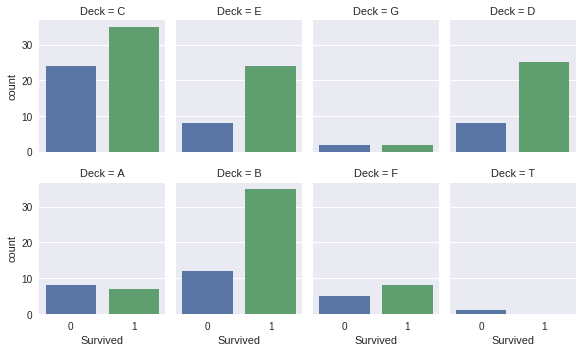

In [112]:
for dataset in full_data:
    dataset["Deck"]=dataset.Cabin.str[0]
g = sns.factorplot("Survived", col="Deck", col_wrap=4,
                    data=train[train.Deck.notnull()],
                    kind="count", size=2.5, aspect=.8);

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked, Name_length, FamilySize, FsizeD, Title, CategoricalAge, CategoricalFare, Deck]
Index: []


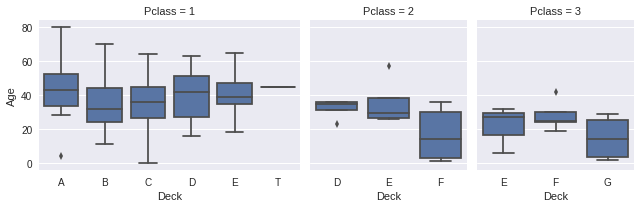

In [113]:
train = train.assign(Deck=train.Deck.astype(object)).sort_values("Deck")
g = sns.FacetGrid(train, col="Pclass", sharex=False,
                  gridspec_kws={"width_ratios": [5, 3, 3]})
g.map(sns.boxplot, "Deck", "Age");
print train[(train.Deck=='D') & (train.Pclass==3)]

In [114]:
train.Deck.fillna('Z', inplace=True)
test.Deck.fillna('Z', inplace=True)

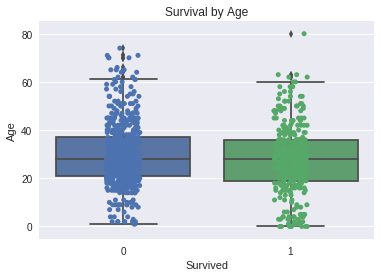

In [115]:
ax = sns.boxplot(x="Survived", y="Age", 
                data=train)
ax = sns.stripplot(x="Survived", y="Age",
                   data=train, jitter=True,
                   edgecolor="gray")
sns.plt.title("Survival by Age",fontsize=12);

In [116]:
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex
    
train['Person'] = train[['Age','Sex']].apply(get_person,axis=1)
test['Person']    = test[['Age','Sex']].apply(get_person,axis=1)

In [134]:
#del train[]
'Name'
'PassengerId'
'SibSp'
'Parch'
'Ticket'

'Ticket'

In [136]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Name_length,FamilySize,FsizeD,Title,CategoricalAge,CategoricalFare,Deck,Person,NlengthD
475,0,1,male,44,52.0000,A14,S,27,1,0.0,Mr,2,3,A,male,2
174,0,1,male,56,30.6958,A7,C,23,1,0.0,Mr,3,2,A,male,1
209,1,1,male,40,31.0000,A31,C,16,1,0.0,Mr,2,2,A,male,0
445,1,1,male,4,81.8583,A34,S,25,3,1.0,Master,0,3,A,child,1
647,1,1,male,56,35.5000,A26,C,35,1,0.0,Rare,3,3,A,male,3


In [98]:
trainX=train['Pclass','CategoricalFare','CategoricalAge','FsizeD','NlengthD']
#get_dummies
#Convert categorical variable into dummy/indicator variables
for dataset in full_data:
    person  = pd.get_dummies(dataset['Person'])
    person.columns = ['Child','Female','Male']
    trainX = trainX.join(person)
    deck
    Title

KeyError: 'Person'

All right so now having cleaned the features and extracted relevant information and dropped the categorical columns our features should now all be numeric, a format suitable to feed into our Machine Learning models. However before we proceed let us generate some simple correlation and distribution plots of our transformed dataset to observe ho

## Visualisations 

# Ensembling & Stacking models

Finally after that brief whirlwind detour with regards to feature engineering and formatting, we finally arrive at the meat and gist of the this notebook.

Creating a Stacking ensemble 

### Helpers via Python Classes

Here we invoke the use of Python's classes to help make it more convenient for us. For any newcomers to programming, one normally hears Classes being used in conjunction with Object-Oriented Programming (OOP). In short, a class helps to extend some code/program for creating objects (variables for old-school peeps) as well as to implement functions and methods specific to that class.

In the section of code below, we essentially write a class *SklearnHelper* that allows one to extend the inbuilt methods (such as train, predict and fit) common to all the Sklearn classifiers. Therefore this cuts out redundancy as  won't need to write the same methods five times if we wanted to invoke five different classifiers.

In [70]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

Bear with me for those who already know this but for people who have not created classes or objects in Python before, let me explain what the code given above does. In creating my base classifiers, I will only use the models already present in the Sklearn library and therefore only extend the class for that.

**def init** : Python standard for invoking the default constructor for the class. This means that when you want to create an object (classifier), you have to give it the parameters of clf (what sklearn classifier you want), seed (random seed) and params (parameters for the classifiers).

The rest of the code are simply methods of the class which simply call the corresponding methods already existing within the sklearn classifiers. 

### Out-of-Fold Predictions

Now as alluded to above in the introductory section, stacking uses predictions of base classifiers as input for training to a second-level model. However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

In [71]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    #ntest = test.shape[0]
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Generating our Base First-Level Models 

So now let us prepare five learning models as our first level classification. These models can all be conveniently invoked via the Sklearn library and are listed as follows:

 1. Random Forest classifier
 2. Extra Trees classifier
 3. AdaBoost classifer
 4. Gradient Boosting classifer
 5. Support Vector Machine

**Parameters**

Just a quick summary of the parameters that we will be listing here for completeness,

**n_jobs** : Number of cores used for the training process. If set to -1, all cores are used.

**n_estimators** : Number of classification trees in your learning model ( set to 10 per default)

**max_depth** : Maximum depth of tree, or how much a node should be expanded. Beware if set to too high  a number would run the risk of overfitting as one would be growing the tree too deep

**verbose** : Controls whether you want to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.

 Please check out the full description via the official Sklearn website. There you will find that there are a whole host of other useful parameters that you can play around with. 

In [72]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

Furthermore, since having mentioned about Objects and classes within the OOP framework, let us now create 5 objects that represent our 5 learning models via our Helper Sklearn Class we defined earlier.

In [73]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

**Creating NumPy arrays out of our train and test sets**

Great. Having prepared our first layer base models as such, we can now ready the training and test test data for input into our classifiers by generating NumPy arrays out of their original dataframes as follows:

In [74]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data
print x_train.shape
print y_train.shape
print x_test.shape

(891, 11)
(891,)
(418, 11)


**Output of the First level Predictions** 

We now feed the training and test data into our 5 base classifiers and use the Out-of-Fold prediction function we defined earlier to generate our first level predictions. Allow a handful of minutes for the chunk of code below to run.

In [36]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


**Feature importances generated from the different classifiers**

Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models and that is to output the importances of the various features in the training and test sets with one very simple line of code.

As per the Sklearn documentation, most of the classifiers are built in with an attribute which returns feature importances by simply typing in **.feature_importances_**. Therefore we will invoke this very useful attribute via our function earliand plot the feature importances as such

In [37]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[ 0.12445554  0.20083112  0.03260738  0.02098833  0.07138707  0.02359255
  0.1058293   0.06519523  0.06838161  0.01358858  0.2731433 ]
[ 0.11914066  0.38008059  0.02154178  0.01768982  0.05588     0.02819713
  0.04674327  0.0849213   0.04436592  0.02129705  0.18014249]
[ 0.028  0.012  0.024  0.064  0.038  0.01   0.684  0.014  0.052  0.004
  0.07 ]
[ 0.07337192  0.04195315  0.09877564  0.02705383  0.07912829  0.0693742
  0.41297561  0.02236114  0.06908596  0.02062222  0.08529805]


So I have not yet figured out how to assign and store the feature importances outright. Therefore I'll print out the values from the code above and then simply copy and paste into Python lists as below (sorry for the lousy hack)

In [39]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
  ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
  ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
  ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
  ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

Create a dataframe from the lists containing the feature importance data for easy plotting via the Plotly package.

In [40]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

**Interactive feature importances via Plotly scatterplots**

I'll use the interactive Plotly package at this juncture to visualise the feature importances values of the different classifiers 

Now let us calculate the mean of all the feature importances and store it as a new column in the feature importance dataframe

In [47]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.028,0.121657,0.067961,0.104741,Pclass,0.080590
1,0.008,0.370983,0.038893,0.218370,Sex,0.159062
2,0.012,0.031296,0.072378,0.044327,Age,0.040000


**Plotly Barplot of Average Feature Importances**

Having obtained the mean feature importance across all our classifiers, we can plot them into a Plotly bar plot as follows:

# Second-Level Predictions from the First-level Output

**First-level output as new features**

Having now obtained our first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier. As per the code below, we are therefore having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.

In [53]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


**Correlation Heatmap of the Second Level Training set**

There have been quite a few articles and Kaggle competition winner stories about the merits of having trained models that are more uncorrelated with one another producing better scores.

In [77]:
print et_oof_train.shape
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
print x_train.shape
print y_train.shape
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

(891, 1)
(891, 5)
(891,)


Having now concatenated and joined both the first-level train and test predictions as x_train and x_test, we can now fit a second-level learning model.

### Second level learning model via XGBoost

Here we choose the eXtremely famous library for boosted tree learning model, XGBoost. It was built to optimize large-scale boosted tree algorithms. For further information about the algorithm, check out the [official documentation][1].

  [1]: https://xgboost.readthedocs.io/en/latest/

Anyways, we call an XGBClassifier and fit it to the first-level train and target data and use the learned model to predict the test data as follows:

In [56]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

Just a quick run down of the XGBoost parameters used in the model:

**max_depth** : How deep you want to grow your tree. Beware if set to too high a number might run the risk of overfitting.

**gamma** : minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.

**eta** : step size shrinkage used in each boosting step to prevent overfitting

**Producing the Submission file**

Finally having trained and fit all our first-level and second-level models, we can now output the predictions into the proper format for submission to the Titanic competition as follows:

In [57]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

**Steps for Further Improvement**

As a closing remark it must be noted that the steps taken above just show a very simple way of producing an ensemble stacker. You hear of ensembles created at the highest level of Kaggle competitions which involves monstrous combinations of stacked classifiers as well as levels of stacking which go to more than 2 levels. 

Some additional steps that may be taken to improve one's score could be:

 1. Implementing a good cross-validation strategy in training the models to find optimal parameter values
 2. Introduce a greater variety of base models for learning. The more uncorrelated the results, the better the final score.

### Conclusion

I have this notebook has been helpful somewhat in introducing a working script for stacking learning models. Again credit must be extended to Faron and Sina. 

For other excellent material on stacking or ensembling in general, refer to the de-facto Must read article on the website MLWave: [Kaggle Ensembling Guide][1]. 

Till next time, Peace Out

  [1]: http://mlwave.com/kaggle-ensembling-guide/